### Import packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
import pickle
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, log_loss
from keras.applications import VGG19
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import LeakyReLU
import json
import gc

np.random.seed(2020)
random_state = 52
CATEGORIES = ["c0","c1","c2","c3","c4","c5","c6","c7","c8","c9"]
PATH_COLAB = "/content/drive/My Drive/Deep Learning Project/progetto/"

TensorFlow 1.x selected.


Using TensorFlow backend.


### Definition of functions

In [0]:
def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

def preprocessing(X, Y, img_rows, img_cols, color_type=3):
    
    Y = np.array(Y, dtype=np.uint8)

    if color_type == 1:
        X = np.array(X, dtype=np.uint8).reshape(-1, img_rows, img_cols, 1)
    else:
        X = np.array(X, dtype=np.uint8).reshape(-1, img_rows, img_cols, 3)

    Y = to_categorical(Y, 10)
    X = X.astype('float32')
    X /= 255
    
    return X, Y

In [0]:
def fine_tuning_vgg19(img_rows, img_cols, color_type, vgg_conv_base, final_layer):

    for layer in vgg_conv_base.layers[:-(final_layer)]:
        layer.trainable = False

    model = Sequential()

    # Add the vgg convolutional base model
    model.add(vgg_conv_base)

    model.add(Flatten())

    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(10, activation = 'softmax'))

    model.summary()

    model.compile(optimizer = "SGD", loss='categorical_crossentropy', metrics = ["accuracy"])

    return model

In [0]:
def training_model(img_rows, img_cols, color_type, final_layer):
    
    df = pd.DataFrame(columns=['k', 'accuracy', 'log_loss', 'architecture'])
    batch_size = 32
    epochs = 20
    sum_score_acc = 0
    sum_score_log_loss = 0

    name_model = 'vgg19_'+str(final_layer)

    for k in range(1,6):

        print("\n\nFold " + str(k) + ' out of 5')

        X_train, Y_train, X_val, Y_val = restore_data(PATH_COLAB + "data/k_" + str(k) + ".dat")
        X_train, Y_train = preprocessing(X_train, Y_train, img_rows, img_cols, color_type)
        X_val, Y_val = preprocessing(X_val, Y_val, img_rows, img_cols, color_type)

        datagen = ImageDataGenerator(
          height_shift_range=0.5, 
          width_shift_range = 0.5, 
          zoom_range = 0.5, 
          rotation_range=20 
        )

        data_generator = datagen.flow(X_train, Y_train, batch_size = 32)

        vgg_conv = VGG19(weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, color_type))
        model = fine_tuning_vgg19(img_rows, img_cols, color_type, vgg_conv, final_layer = final_layer)

        kfold_weights_path = os.path.join(PATH_COLAB + 'architecture/'+ name_model, 'weights_kfold_' + str(k) + '.h5')

        if not os.path.isfile(kfold_weights_path) or RESTORE_WEIGHTS == False:
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0)
            ]
            class_weights = class_weight.compute_sample_weight(class_weight='balanced', y=Y_train)
            
            history = model.fit_generator(data_generator, steps_per_epoch = len(X_train) // batch_size, 
                                epochs=epochs, shuffle=True, verbose=0, validation_data=(X_val, Y_val),
                                class_weight=class_weights, callbacks=callbacks)
            
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

            acc = history.history['acc']
            val_acc = history.history['val_acc']
            n_epoch = range(len(acc))
            axes[0].plot(n_epoch, acc, color='mediumseagreen',marker='.', label='training')
            axes[0].plot(n_epoch, val_acc, color='steelblue', marker='.', label='validation')
            axes[0].set_title('Training and validation accuracy')
            axes[0].set_xlabel('epochs')
            axes[0].set_ylabel('accuracy')
            axes[0].legend(loc="lower right")

            loss = history.history['loss']
            val_loss = history.history['val_loss']
            axes[1].plot(n_epoch, loss, color='mediumseagreen',marker='.', label='training')
            axes[1].plot(n_epoch, val_loss, color='steelblue', marker='.', label='validation')
            axes[1].set_title('Training and validation loss')
            axes[1].set_xlabel('epochs')
            axes[1].set_ylabel('loss')
            axes[1].legend(loc="upper right")
            fig.tight_layout()
            plt.show()

        if os.path.isfile(kfold_weights_path):
            model.load_weights(kfold_weights_path)

        predictions_val = model.predict(X_val, batch_size=batch_size, verbose=1)

        predictions_val_arg = [y.argmax() for y in predictions_val]
        Y_val_arg = [y.argmax() for y in Y_val]

        predictions_val_arg = np.array(predictions_val_arg)  
        Y_val_arg = np.array(Y_val_arg)

        score_acc = accuracy_score(Y_val_arg, predictions_val_arg)
        score_log_loss = log_loss(Y_val, predictions_val)
        
        print('Score Accuracy: ', score_acc)
        print('Score Log Loss: ', score_log_loss)

        sum_score_acc += score_acc*X_val.shape[0]
        sum_score_log_loss += score_log_loss*X_val.shape[0]

        print(classification_report(Y_val_arg, predictions_val_arg, target_names=CATEGORIES))

        df = df.append({'k': k, 'accuracy':score_acc, 'log_loss':score_log_loss, 'architecture':name_model}, ignore_index=True)
    
    score_acc = sum_score_acc/(X_train.shape[0] + X_val.shape[0])
    print("Avg Accuracy train indipendent: ", score_acc)

    score_log_loss = sum_score_log_loss/(X_train.shape[0] + X_val.shape[0])
    print("Avg Log Loss train indipendent: ", score_log_loss)

    df['weighted_mean_loss'] = score_log_loss
    df['weighted_mean_acc'] = score_acc

    df.to_csv(PATH_COLAB+'dataframes/'+name_model+'.csv')

    return df



In [0]:
RESTORE_WEIGHTS = False

### VGG19_trainable_1
It refers to the architecture where the last block of VGG19 and the extra_layers are trained together



Fold 1 out of 5




80142336/80134624 [==============================] - 1s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
___________________________________________

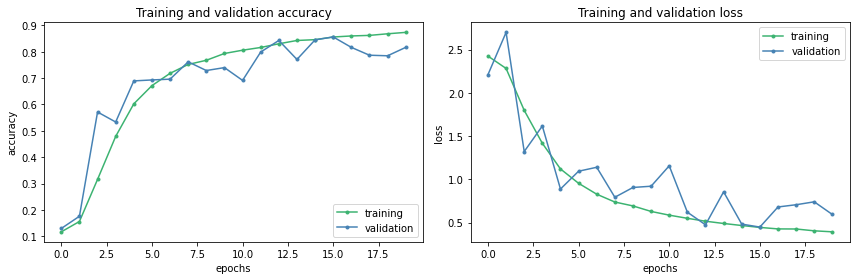

4703/4703 [==============================] - 5s 1ms/step
Score Accuracy:  0.8560493302147565
Score Log Loss:  0.44811437673278093
              precision    recall  f1-score   support

          c0       0.84      0.63      0.72       455
          c1       0.92      0.82      0.87       466
          c2       0.94      0.92      0.93       515
          c3       0.96      0.92      0.94       487
          c4       0.87      0.94      0.90       500
          c5       1.00      0.95      0.98       498
          c6       0.83      0.87      0.85       483
          c7       0.96      0.92      0.94       425
          c8       0.61      0.87      0.72       416
          c9       0.70      0.70      0.70       458

    accuracy                           0.86      4703
   macro avg       0.86      0.85      0.85      4703
weighted avg       0.87      0.86      0.86      4703



Fold 2 out of 5
Model: "sequential_2"
_________________________________________________________________
Layer

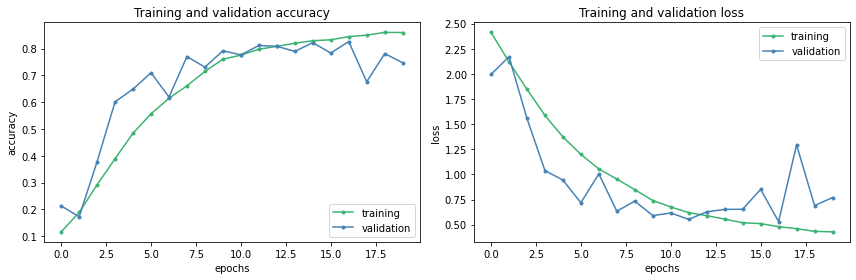

5303/5303 [==============================] - 6s 1ms/step
Score Accuracy:  0.8259475768432962
Score Log Loss:  0.5305513760505381
              precision    recall  f1-score   support

          c0       0.69      0.74      0.72       637
          c1       0.98      0.82      0.89       534
          c2       0.98      0.64      0.78       518
          c3       0.99      0.92      0.95       554
          c4       0.89      0.99      0.94       529
          c5       1.00      0.97      0.98       534
          c6       0.70      0.85      0.77       541
          c7       0.95      1.00      0.97       459
          c8       0.59      0.77      0.67       440
          c9       0.67      0.58      0.62       557

    accuracy                           0.83      5303
   macro avg       0.84      0.83      0.83      5303
weighted avg       0.84      0.83      0.83      5303



Fold 3 out of 5
Model: "sequential_3"
_________________________________________________________________
Layer 

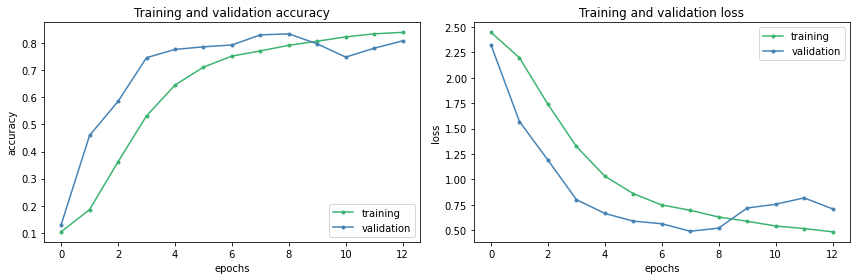

3932/3932 [==============================] - 4s 1ms/step
Score Accuracy:  0.8290946083418108
Score Log Loss:  0.4912874861679216
              precision    recall  f1-score   support

          c0       0.69      0.79      0.74       419
          c1       0.97      0.75      0.85       409
          c2       0.88      0.90      0.89       409
          c3       0.99      0.85      0.92       410
          c4       0.80      1.00      0.89       413
          c5       1.00      0.97      0.98       414
          c6       0.82      0.81      0.81       416
          c7       0.95      0.76      0.85       378
          c8       0.53      0.83      0.64       317
          c9       0.84      0.59      0.69       347

    accuracy                           0.83      3932
   macro avg       0.85      0.82      0.83      3932
weighted avg       0.85      0.83      0.83      3932



Fold 4 out of 5
Model: "sequential_4"
_________________________________________________________________
Layer 

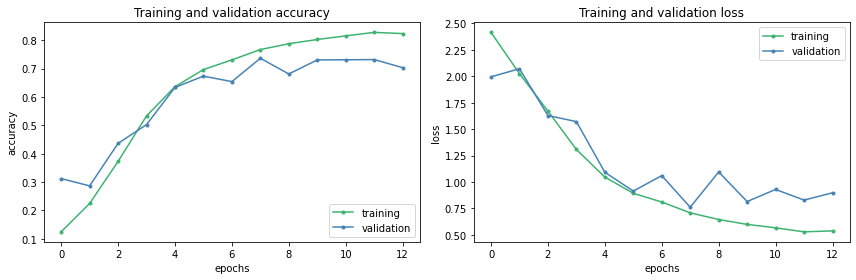

4310/4310 [==============================] - 5s 1ms/step
Score Accuracy:  0.7366589327146171
Score Log Loss:  0.7619183826098856
              precision    recall  f1-score   support

          c0       0.79      0.47      0.59       501
          c1       0.85      0.66      0.74       408
          c2       0.83      0.50      0.62       429
          c3       0.73      0.98      0.84       459
          c4       0.85      0.89      0.87       437
          c5       0.74      0.95      0.83       452
          c6       0.91      0.90      0.90       435
          c7       0.66      0.94      0.78       402
          c8       0.56      0.84      0.67       376
          c9       0.46      0.25      0.32       411

    accuracy                           0.74      4310
   macro avg       0.74      0.74      0.72      4310
weighted avg       0.74      0.74      0.72      4310



Fold 5 out of 5
Model: "sequential_5"
_________________________________________________________________
Layer 

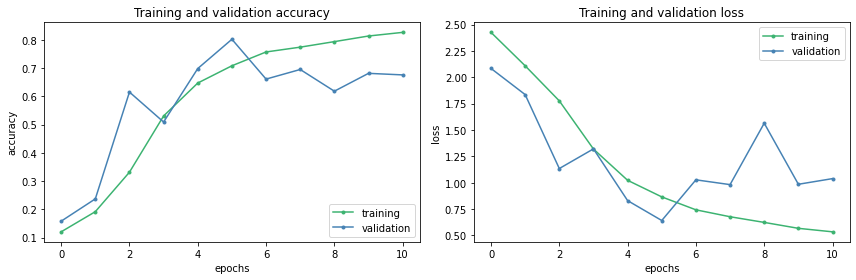

4176/4176 [==============================] - 5s 1ms/step
Score Accuracy:  0.8022030651340997
Score Log Loss:  0.641686933375567
              precision    recall  f1-score   support

          c0       0.71      0.76      0.73       477
          c1       0.97      0.85      0.91       450
          c2       0.78      0.95      0.86       446
          c3       0.81      0.95      0.88       436
          c4       0.88      0.71      0.79       447
          c5       0.94      0.98      0.96       414
          c6       0.73      0.81      0.77       450
          c7       0.96      0.77      0.85       338
          c8       0.63      0.51      0.56       362
          c9       0.66      0.67      0.66       356

    accuracy                           0.80      4176
   macro avg       0.81      0.80      0.80      4176
weighted avg       0.81      0.80      0.80      4176

Avg Accuracy train indipendent:  0.8112290403139494
Avg Log Loss train indipendent:  0.5715434855247733


,k,accuracy,log_loss,architecture,weighted_mean_loss,weighted_mean_acc
0,1,0.856049,0.448114,vgg19_5,0.571543,0.811229
1,2,0.825948,0.530551,vgg19_5,0.571543,0.811229
2,3,0.829095,0.491287,vgg19_5,0.571543,0.811229
3,4,0.736659,0.761918,vgg19_5,0.571543,0.811229
4,5,0.802203,0.641687,vgg19_5,0.571543,0.811229


In [0]:
training_model(128,128,3, final_layer=5)

### VGG19_trainable_2
It refers to the architecture where the last two blocks of VGG19 and the extra_layers are trained together



Fold 1 out of 5











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)   

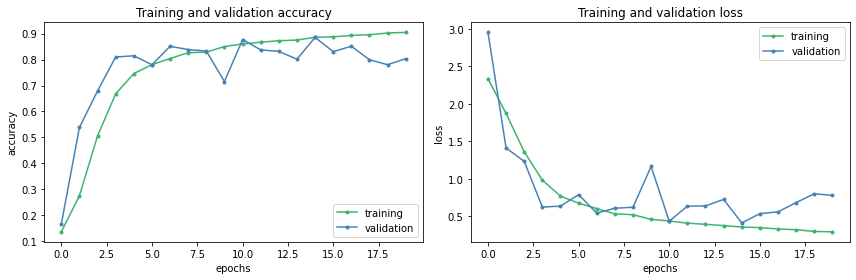

4703/4703 [==============================] - 5s 1ms/step
Score Accuracy:  0.8856049330214757
Score Log Loss:  0.4139208820491996
              precision    recall  f1-score   support

          c0       0.78      0.73      0.75       455
          c1       0.99      0.95      0.97       466
          c2       0.99      0.83      0.90       515
          c3       0.99      0.93      0.96       487
          c4       0.86      0.96      0.91       500
          c5       1.00      0.93      0.97       498
          c6       0.94      0.99      0.96       483
          c7       0.80      1.00      0.89       425
          c8       0.70      0.86      0.77       416
          c9       0.82      0.66      0.73       458

    accuracy                           0.89      4703
   macro avg       0.89      0.88      0.88      4703
weighted avg       0.89      0.89      0.89      4703



Fold 2 out of 5
Model: "sequential_2"
_________________________________________________________________
Layer 

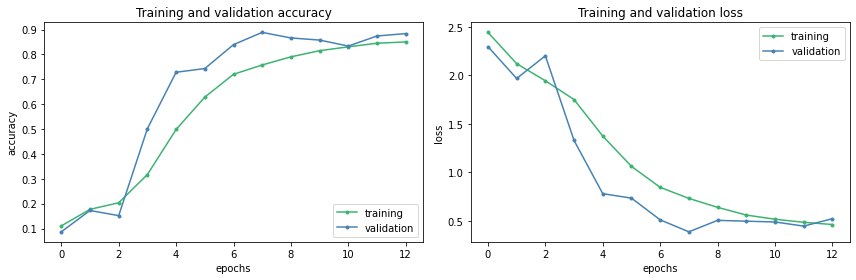

5303/5303 [==============================] - 6s 1ms/step
Score Accuracy:  0.8885536488779936
Score Log Loss:  0.38892614251316654
              precision    recall  f1-score   support

          c0       0.69      0.87      0.77       637
          c1       0.96      0.94      0.95       534
          c2       0.92      0.88      0.90       518
          c3       0.98      0.99      0.99       554
          c4       0.97      0.99      0.98       529
          c5       1.00      0.99      1.00       534
          c6       0.89      0.97      0.93       541
          c7       0.94      1.00      0.97       459
          c8       0.76      0.67      0.72       440
          c9       0.82      0.57      0.67       557

    accuracy                           0.89      5303
   macro avg       0.89      0.89      0.89      5303
weighted avg       0.89      0.89      0.89      5303



Fold 3 out of 5
Model: "sequential_3"
_________________________________________________________________
Layer

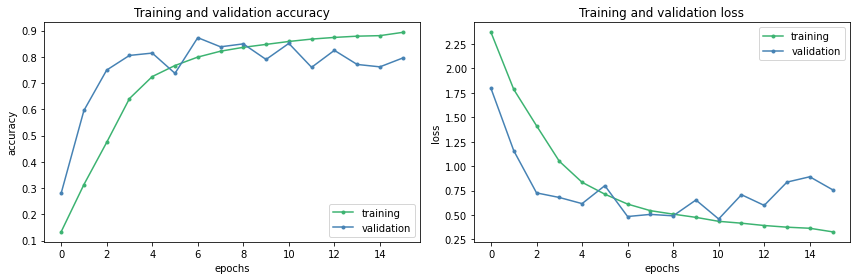

3932/3932 [==============================] - 4s 1ms/step
Score Accuracy:  0.8509664292980671
Score Log Loss:  0.45889678911147275
              precision    recall  f1-score   support

          c0       0.69      0.63      0.66       419
          c1       1.00      0.88      0.94       409
          c2       1.00      0.87      0.93       409
          c3       0.98      0.95      0.96       410
          c4       0.90      1.00      0.95       413
          c5       0.85      1.00      0.92       414
          c6       0.91      0.88      0.89       416
          c7       0.96      0.81      0.88       378
          c8       0.56      0.88      0.68       317
          c9       0.75      0.58      0.65       347

    accuracy                           0.85      3932
   macro avg       0.86      0.85      0.85      3932
weighted avg       0.87      0.85      0.85      3932



Fold 4 out of 5
Model: "sequential_4"
_________________________________________________________________
Layer

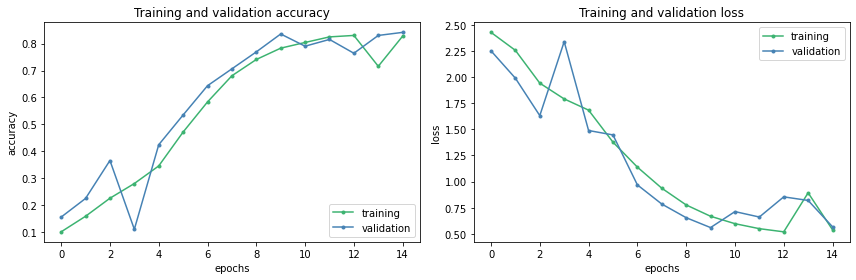

4310/4310 [==============================] - 5s 1ms/step
Score Accuracy:  0.8354988399071925
Score Log Loss:  0.5604000989743293
              precision    recall  f1-score   support

          c0       0.89      0.83      0.86       501
          c1       0.93      0.96      0.95       408
          c2       0.87      0.65      0.74       429
          c3       0.91      0.99      0.95       459
          c4       0.98      0.96      0.97       437
          c5       1.00      0.85      0.92       452
          c6       0.74      0.94      0.83       435
          c7       1.00      0.66      0.80       402
          c8       0.64      0.64      0.64       376
          c9       0.57      0.82      0.67       411

    accuracy                           0.84      4310
   macro avg       0.85      0.83      0.83      4310
weighted avg       0.86      0.84      0.84      4310



Fold 5 out of 5
Model: "sequential_5"
_________________________________________________________________
Layer 

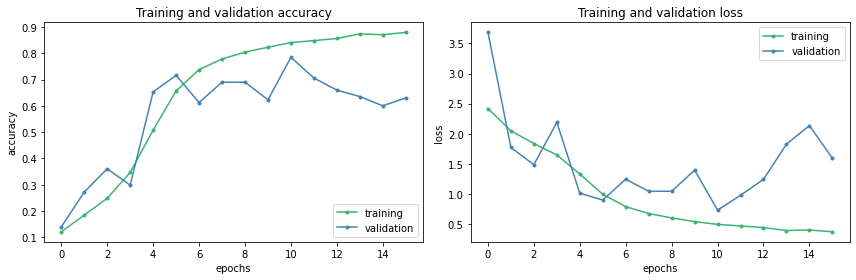

4176/4176 [==============================] - 5s 1ms/step
Score Accuracy:  0.7842432950191571
Score Log Loss:  0.7323614577472672
              precision    recall  f1-score   support

          c0       0.76      0.75      0.76       477
          c1       0.99      0.77      0.87       450
          c2       0.95      0.66      0.78       446
          c3       1.00      0.93      0.96       436
          c4       0.98      0.85      0.91       447
          c5       0.86      0.97      0.91       414
          c6       0.86      0.88      0.87       450
          c7       0.94      0.80      0.87       338
          c8       0.37      0.81      0.51       362
          c9       0.52      0.36      0.43       356

    accuracy                           0.78      4176
   macro avg       0.82      0.78      0.79      4176
weighted avg       0.83      0.78      0.80      4176

Avg Accuracy train indipendent:  0.8517213699607563
Avg Log Loss train indipendent:  0.5033532505771925


,k,accuracy,log_loss,architecture,weighted_mean_loss,weighted_mean_acc
0,1,0.885605,0.413921,vgg19_10,0.503353,0.851721
1,2,0.888554,0.388926,vgg19_10,0.503353,0.851721
2,3,0.850966,0.458897,vgg19_10,0.503353,0.851721
3,4,0.835499,0.560400,vgg19_10,0.503353,0.851721
4,5,0.784243,0.732361,vgg19_10,0.503353,0.851721


In [0]:
training_model(128,128,3, final_layer=10)